In [1]:
%%configure -f
{ "conf":{
"spark.pyspark.virtualenv.enabled": "false"
}}

In [2]:
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import from_unixtime
from pyspark.sql.window import Window
from pyspark.sql import functions as F

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
7,application_1586103322681_0009,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
%local
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = spark.sql("""select from_unixtime(unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')) as date, 
sum(confirmed) as numConfirmed, sum(deaths) as numDeaths,sum(recovered) as numRecovered,admin2,province_state, 
concat(admin2, ' - ', province_state) as county 
from covid19.jhu_daily_new
where year='2020' and int(month) > 2
and country_region = 'US' and 
( province_state = 'Virginia' or province_state = 'Maryland' or 
province_state = 'California' or province_state = 'Washington' or province_state = 'District of Columbia' ) 
group by unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd'),admin2,province_state
order by unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd') asc, sum(confirmed) desc""")
df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------------+---------+------------+--------------------+--------------------+--------------------+
|               date|numConfirmed|numDeaths|numRecovered|              admin2|      province_state|              county|
+-------------------+------------+---------+------------+--------------------+--------------------+--------------------+
|2020-03-22 00:00:00|        1040|       75|           0|                King|          Washington|   King - Washington|
|2020-03-22 00:00:00|         480|       10|           0|           Snohomish|          Washington|Snohomish - Washi...|
|2020-03-22 00:00:00|         407|        5|           0|         Los Angeles|          California|Los Angeles - Cal...|
|2020-03-22 00:00:00|         263|        8|           0|         Santa Clara|          California|Santa Clara - Cal...|
|2020-03-22 00:00:00|         164|        0|           0|          Unassigned|          Washington|Unassigned - Wash...|
|2020-03-22 00:00:00|         15

In [5]:
%%spark -o df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

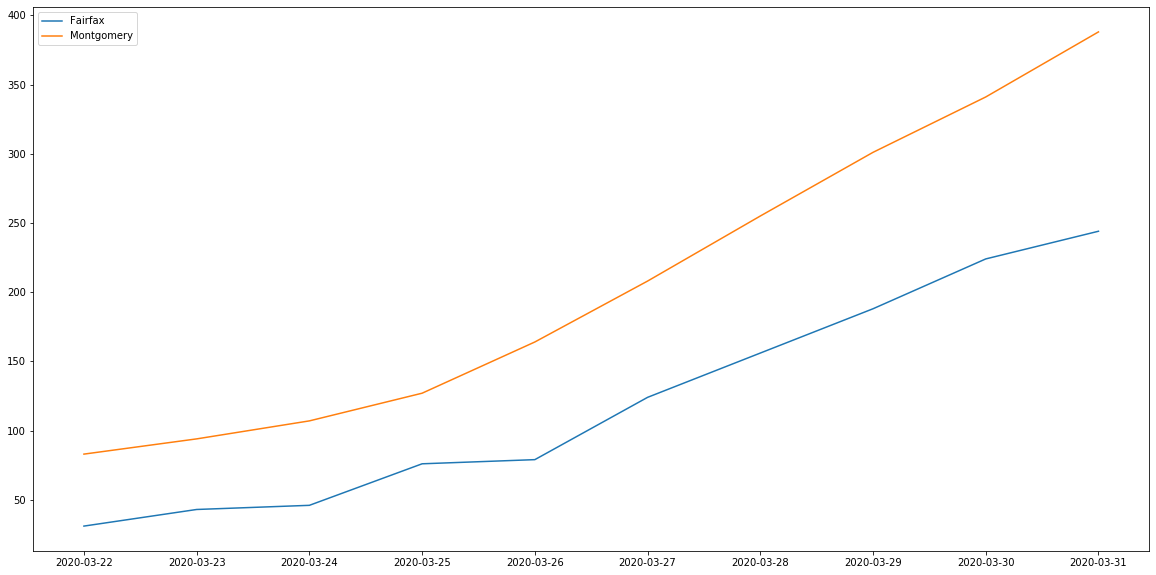

In [6]:
%local
plt.figure(figsize=(20,10))
plt.plot('date','numConfirmed',data=df.loc[(df['admin2'] == 'Fairfax') & (df['province_state'] == 'Virginia')],label="Fairfax")
plt.plot('date','numConfirmed',data=df.loc[(df['admin2'] == 'Montgomery') & (df['province_state'] == 'Maryland')],label="Montgomery")
plt.legend()
plt.show()


In [7]:
df_topcounties = spark.sql("""select concat(admin2, ' - ', province_state) as county 
from covid19.jhu_daily_new
where year='2020' and int(month) > 2
and country_region = 'US' and 
( province_state = 'Virginia' or province_state = 'Maryland' or province_state = 'District of Columbia' or 
( province_state = 'California' and admin2 = 'Los Angeles' ) or 
( province_state = 'Washington' and admin2 = 'King' ) ) 
group by admin2,province_state
order by max(confirmed) desc
limit 20""")
df_topcounties.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|              county|
+--------------------+
|Los Angeles - Cal...|
|   King - Washington|
|District of Colum...|
|Prince George's -...|
|Montgomery - Mary...|
|Baltimore - Maryland|
|  Fairfax - Virginia|
|Baltimore City - ...|
|Anne Arundel - Ma...|
|   Howard - Maryland|
|  Henrico - Virginia|
|Arlington - Virginia|
|Prince William - ...|
|Virginia Beach - ...|
|  Loudoun - Virginia|
|  Carroll - Maryland|
|Frederick - Maryland|
|James City - Virg...|
|  Charles - Maryland|
|Chesterfield - Vi...|
+--------------------+

In [8]:
%spark -o df_topcounties

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

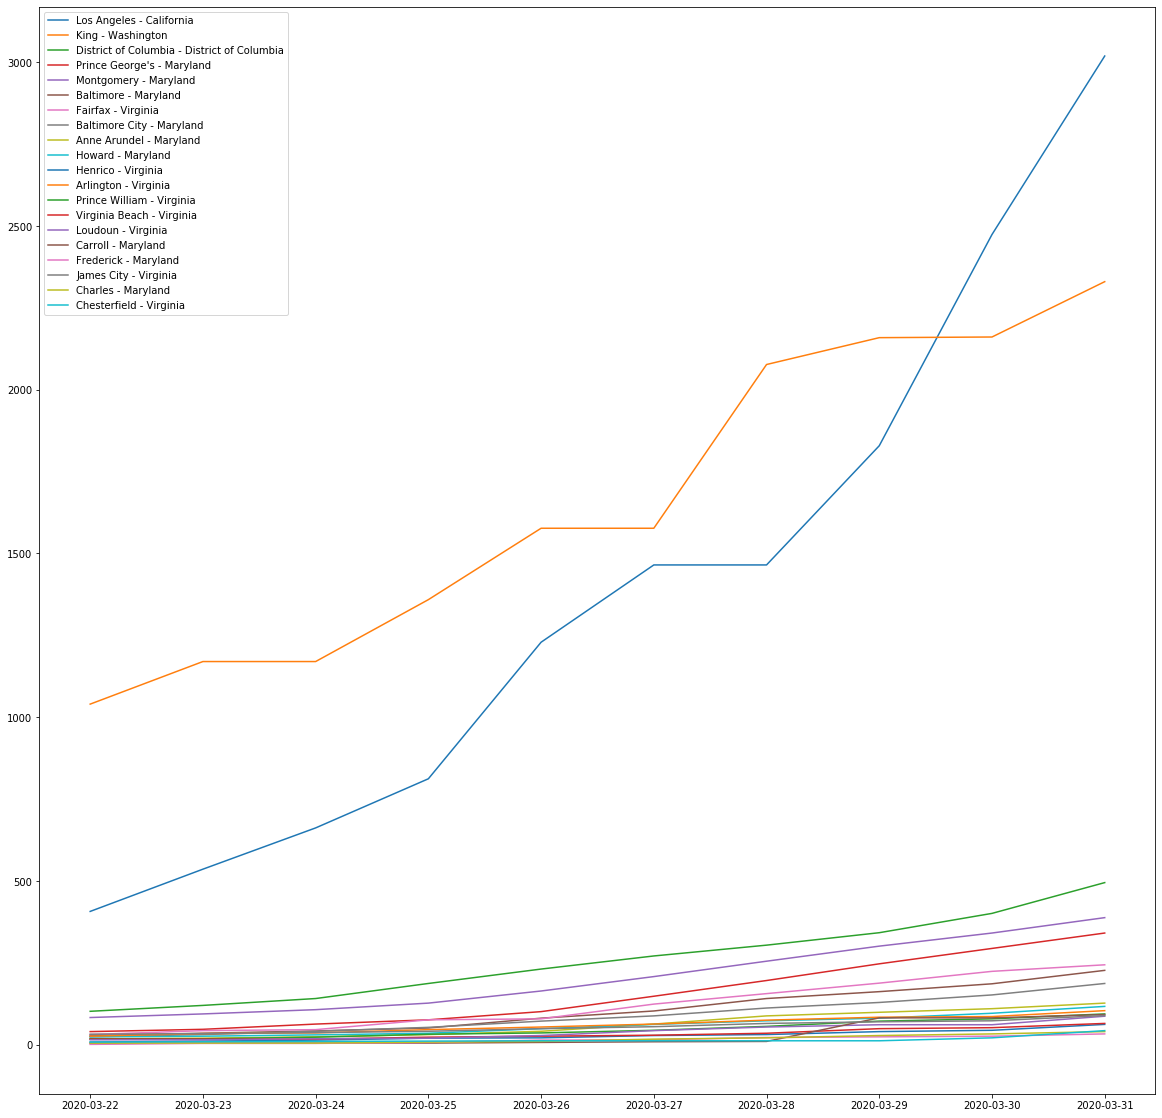

In [9]:
%local
plt.figure(figsize=(20,20))
for index in df_topcounties.index:
  plt.plot('date', 'numConfirmed', data=df.loc[df['county']==df_topcounties['county'][index]],label=df_topcounties['county'][index])
  plt.text
plt.legend()
plt.show()

In [10]:
df_dmv = spark.sql("""select max(confirmed) as numConfirmed, admin2, province_state 
from covid19.jhu_daily_new
where year='2020' and int(month) > 2
and country_region = 'US' and 
( province_state = 'Virginia' or province_state = 'Maryland' or province_state = 'District of Columbia' ) 
group by admin2,province_state
order by max(confirmed) desc""")
df_dmv.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+--------------------+--------------------+
|numConfirmed|              admin2|      province_state|
+------------+--------------------+--------------------+
|        1002|District of Columbia|District of Columbia|
|         785|     Prince George's|            Maryland|
|         693|          Montgomery|            Maryland|
|         590|           Baltimore|            Maryland|
|         426|             Fairfax|            Virginia|
|         394|      Baltimore City|            Maryland|
|         319|        Anne Arundel|            Maryland|
|         199|              Howard|            Maryland|
|         194|             Henrico|            Virginia|
|         181|           Arlington|            Virginia|
|         175|      Prince William|            Virginia|
|         170|      Virginia Beach|            Virginia|
|         167|             Loudoun|            Virginia|
|         142|             Carroll|            Maryland|
|         120|           Freder

In [11]:
%spark -o df_dmv

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
df_topcounties_dmv = spark.sql("""select concat(admin2, ' - ', province_state) as county 
from covid19.jhu_daily_new
where year='2020' and int(month) > 2
and country_region = 'US' and 
( province_state = 'Virginia' or province_state = 'Maryland' or province_state = 'District of Columbia' ) 
group by admin2,province_state
order by max(confirmed) desc
limit 10""")
df_topcounties_dmv.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|              county|
+--------------------+
|District of Colum...|
|Prince George's -...|
|Montgomery - Mary...|
|Baltimore - Maryland|
|  Fairfax - Virginia|
|Baltimore City - ...|
|Anne Arundel - Ma...|
|   Howard - Maryland|
|  Henrico - Virginia|
|Arlington - Virginia|
+--------------------+

In [13]:
%spark -o df_topcounties_dmv

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

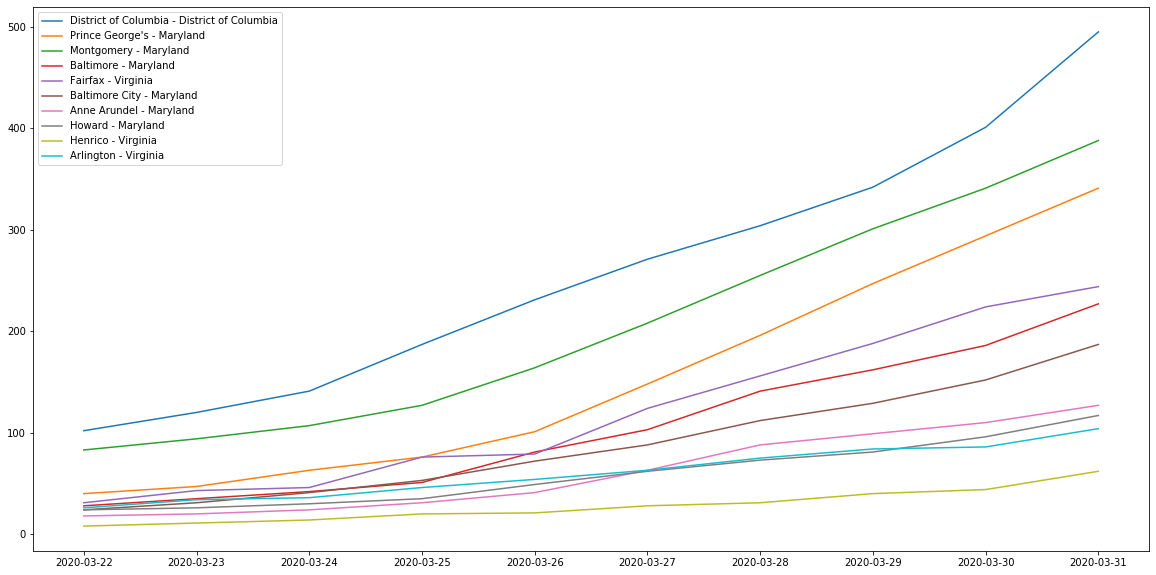

In [14]:
%local
plt.figure(figsize=(20,10))
for index in df_topcounties_dmv.index:
  plt.plot('date', 'numConfirmed', data=df.loc[df['county']==df_topcounties_dmv['county'][index]],label=df_topcounties_dmv['county'][index])
  plt.text
plt.legend()
plt.show()

In [15]:
df_fairfax = spark.sql("""select from_unixtime(unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')) as date, 
admin2 as county, sum(confirmed) as numConfirmed 
from covid19.jhu_daily_new
where year='2020' and int(month) > 2
and country_region = 'US' and 
( province_state = 'Virginia' ) and ( admin2 = 'Fairfax' ) 
group by admin2, unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd'),admin2,province_state
order by unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd') asc, sum(confirmed) desc""")
df_fairfax.show()

my_window = Window.partitionBy().orderBy("date")

df_fairfax = df_fairfax.withColumn("dayBefore", F.lag(df_fairfax.numConfirmed).over(my_window))
df_fairfax = df_fairfax.withColumn("change", F.when(F.isnull(df_fairfax.numConfirmed - df_fairfax.dayBefore), 0).otherwise(df_fairfax.numConfirmed - df_fairfax.dayBefore))

df_fairfax.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------+------------+
|               date| county|numConfirmed|
+-------------------+-------+------------+
|2020-03-22 00:00:00|Fairfax|          31|
|2020-03-23 00:00:00|Fairfax|          43|
|2020-03-24 00:00:00|Fairfax|          46|
|2020-03-25 00:00:00|Fairfax|          76|
|2020-03-26 00:00:00|Fairfax|          79|
|2020-03-27 00:00:00|Fairfax|         124|
|2020-03-28 00:00:00|Fairfax|         156|
|2020-03-29 00:00:00|Fairfax|         188|
|2020-03-30 00:00:00|Fairfax|         224|
|2020-03-31 00:00:00|Fairfax|         244|
|2020-04-01 00:00:00|Fairfax|         288|
|2020-04-02 00:00:00|Fairfax|         328|
|2020-04-03 00:00:00|Fairfax|         372|
|2020-04-04 00:00:00|Fairfax|         387|
|2020-04-05 00:00:00|Fairfax|         426|
+-------------------+-------+------------+

+-------------------+-------+------------+---------+------+
|               date| county|numConfirmed|dayBefore|change|
+-------------------+-------+------------+---------+------+
|2

In [16]:
%spark -o df_fairfax

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
df_arlington = spark.sql("""select from_unixtime(unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')) as date, 
admin2 as county, sum(confirmed) as numConfirmed 
from covid19.jhu_daily_new
where year='2020' and int(month) > 2
and country_region = 'US' and 
( province_state = 'Virginia' ) and ( admin2 = 'Arlington' ) 
group by admin2, unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd'),admin2,province_state
order by unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd') asc, sum(confirmed) desc""")
df_arlington.show()

my_window = Window.partitionBy().orderBy("date")

df_arlington = df_arlington.withColumn("dayBefore", F.lag(df_arlington.numConfirmed).over(my_window))
df_arlington = df_arlington.withColumn("change", F.when(F.isnull(df_arlington.numConfirmed - df_arlington.dayBefore), 0).otherwise(df_arlington.numConfirmed - df_arlington.dayBefore))

df_arlington.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+---------+------------+
|               date|   county|numConfirmed|
+-------------------+---------+------------+
|2020-03-22 00:00:00|Arlington|          26|
|2020-03-23 00:00:00|Arlington|          34|
|2020-03-24 00:00:00|Arlington|          36|
|2020-03-25 00:00:00|Arlington|          46|
|2020-03-26 00:00:00|Arlington|          54|
|2020-03-27 00:00:00|Arlington|          63|
|2020-03-28 00:00:00|Arlington|          75|
|2020-03-29 00:00:00|Arlington|          84|
|2020-03-30 00:00:00|Arlington|          86|
|2020-03-31 00:00:00|Arlington|         104|
|2020-04-01 00:00:00|Arlington|         119|
|2020-04-02 00:00:00|Arlington|         128|
|2020-04-03 00:00:00|Arlington|         135|
|2020-04-04 00:00:00|Arlington|         150|
|2020-04-05 00:00:00|Arlington|         181|
+-------------------+---------+------------+

+-------------------+---------+------------+---------+------+
|               date|   county|numConfirmed|dayBefore|change|
+-------------------

In [18]:
%spark -o df_arlington

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
df_montgomery = spark.sql("""select from_unixtime(unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')) as date, 
admin2 as county, sum(confirmed) as numConfirmed 
from covid19.jhu_daily_new
where year='2020' and int(month) > 2
and country_region = 'US' and 
( province_state = 'Maryland' ) and ( admin2 = 'Montgomery' ) 
group by admin2, unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd'),admin2,province_state
order by unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd') asc, sum(confirmed) desc""")
df_montgomery.show()

my_window = Window.partitionBy().orderBy("date")

df_montgomery = df_montgomery.withColumn("dayBefore", F.lag(df_montgomery.numConfirmed).over(my_window))
df_montgomery = df_montgomery.withColumn("change", F.when(F.isnull(df_montgomery.numConfirmed - df_montgomery.dayBefore), 0).otherwise(df_montgomery.numConfirmed - df_montgomery.dayBefore))

df_montgomery.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------+------------+
|               date|    county|numConfirmed|
+-------------------+----------+------------+
|2020-03-22 00:00:00|Montgomery|          83|
|2020-03-23 00:00:00|Montgomery|          94|
|2020-03-24 00:00:00|Montgomery|         107|
|2020-03-25 00:00:00|Montgomery|         127|
|2020-03-26 00:00:00|Montgomery|         164|
|2020-03-27 00:00:00|Montgomery|         208|
|2020-03-28 00:00:00|Montgomery|         255|
|2020-03-29 00:00:00|Montgomery|         301|
|2020-03-30 00:00:00|Montgomery|         341|
|2020-03-31 00:00:00|Montgomery|         388|
|2020-04-01 00:00:00|Montgomery|         447|
|2020-04-02 00:00:00|Montgomery|         498|
|2020-04-03 00:00:00|Montgomery|         566|
|2020-04-04 00:00:00|Montgomery|         640|
|2020-04-05 00:00:00|Montgomery|         693|
+-------------------+----------+------------+

+-------------------+----------+------------+---------+------+
|               date|    county|numConfirmed|dayBefore|change|

In [20]:
%spark -o df_montgomery

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

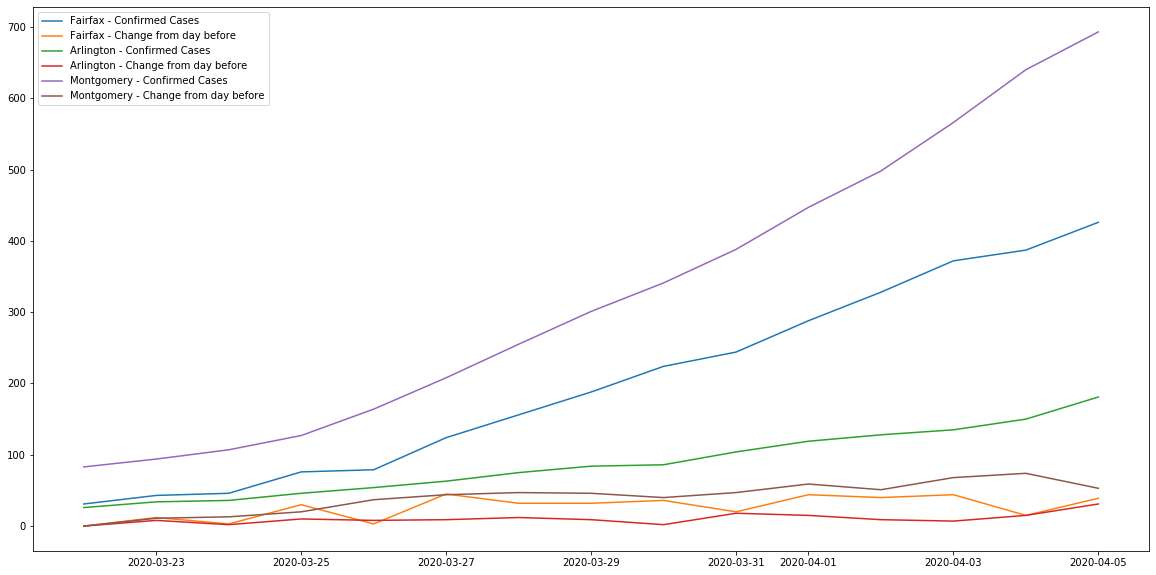

In [21]:
%local
plt.figure(figsize=(20,10))
plt.plot('date', 'numConfirmed', data=df_fairfax, label="Fairfax - Confirmed Cases")
plt.plot('date', 'change', data=df_fairfax, label="Fairfax - Change from day before")
plt.plot('date', 'numConfirmed', data=df_arlington, label="Arlington - Confirmed Cases")
plt.plot('date', 'change', data=df_arlington, label="Arlington - Change from day before")
plt.plot('date', 'numConfirmed', data=df_montgomery, label="Montgomery - Confirmed Cases")
plt.plot('date', 'change', data=df_montgomery, label="Montgomery - Change from day before")
plt.text
plt.legend()
plt.show()

In [22]:
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import from_unixtime
df_states_dmv = spark.sql("""select from_unixtime(unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')) as date,
sum(confirmed) as numConfirmed, sum(deaths) as numDeaths, province_state  
from covid19.jhu_daily_new
where year = '2020' and int(month) > 2 and
( province_state = 'Virginia' or province_state = 'Maryland' or province_state = 'District of Columbia' )
group by year, month, day, province_state
order by year, month, day, sum(confirmed) desc""")
df_states_dmv.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------------+---------+--------------------+
|               date|numConfirmed|numDeaths|      province_state|
+-------------------+------------+---------+--------------------+
|2020-03-22 00:00:00|         244|        3|            Maryland|
|2020-03-22 00:00:00|         220|        6|            Virginia|
|2020-03-22 00:00:00|         102|        2|District of Columbia|
|2020-03-23 00:00:00|         290|        3|            Maryland|
|2020-03-23 00:00:00|         254|        6|            Virginia|
|2020-03-23 00:00:00|         120|        2|District of Columbia|
|2020-03-24 00:00:00|         349|        4|            Maryland|
|2020-03-24 00:00:00|         293|        9|            Virginia|
|2020-03-24 00:00:00|         141|        2|District of Columbia|
|2020-03-25 00:00:00|         425|        4|            Maryland|
|2020-03-25 00:00:00|         396|        9|            Virginia|
|2020-03-25 00:00:00|         187|        2|District of Columbia|
|2020-03-2

In [23]:
%spark -o df_states_dmv

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

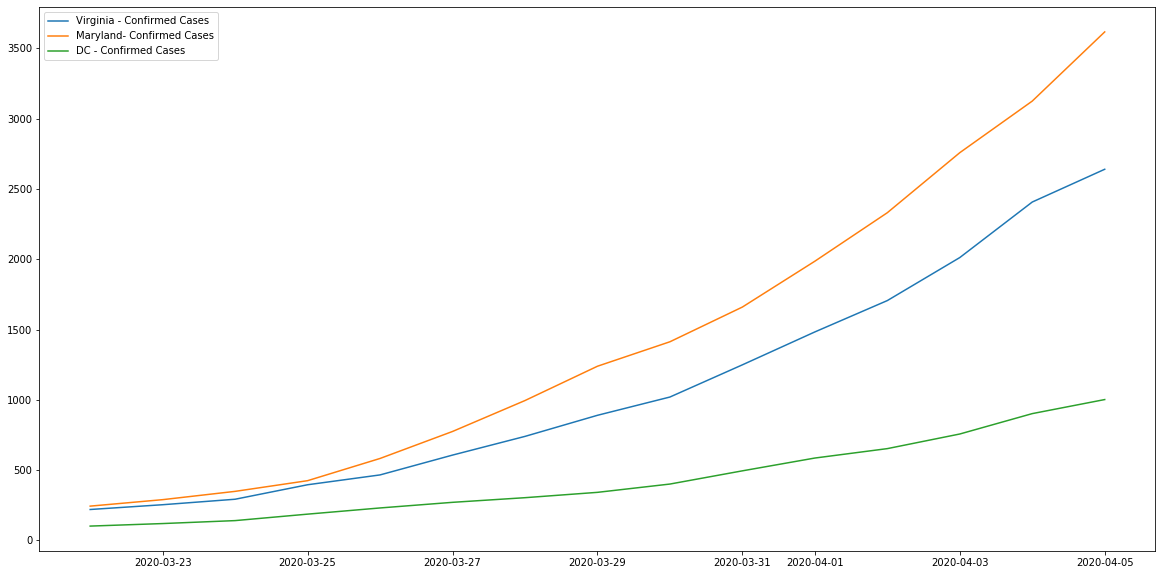

In [24]:
%local
plt.figure(figsize=(20,10))
plt.plot('date', 'numConfirmed', data=df_states_dmv.loc[df_states_dmv['province_state'] == 'Virginia'], label="Virginia - Confirmed Cases")
plt.plot('date', 'numConfirmed', data=df_states_dmv.loc[df_states_dmv['province_state'] == 'Maryland'], label="Maryland- Confirmed Cases")
plt.plot('date', 'numConfirmed', data=df_states_dmv.loc[df_states_dmv['province_state'] == 'District of Columbia'], label="DC - Confirmed Cases")
plt.text
plt.legend()
plt.show()

In [25]:
df_dmv = df_fairfax.union(df_arlington).union(df_montgomery)
movAvgSpec = Window.partitionBy("county").orderBy("date").rowsBetween(-3,0)

df_dmv_movAvg = df_dmv.withColumn( "movingAverage", F.avg("change").over(movAvgSpec) )
df_dmv_movAvg.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------+------------+---------+------+------------------+
|               date|    county|numConfirmed|dayBefore|change|     movingAverage|
+-------------------+----------+------------+---------+------+------------------+
|2020-03-22 00:00:00|Montgomery|          83|     null|     0|               0.0|
|2020-03-23 00:00:00|Montgomery|          94|       83|    11|               5.5|
|2020-03-24 00:00:00|Montgomery|         107|       94|    13|               8.0|
|2020-03-25 00:00:00|Montgomery|         127|      107|    20|              11.0|
|2020-03-26 00:00:00|Montgomery|         164|      127|    37|             20.25|
|2020-03-27 00:00:00|Montgomery|         208|      164|    44|              28.5|
|2020-03-28 00:00:00|Montgomery|         255|      208|    47|              37.0|
|2020-03-29 00:00:00|Montgomery|         301|      255|    46|              43.5|
|2020-03-30 00:00:00|Montgomery|         341|      301|    40|             44.25|
|2020-03-31 00:0

In [26]:
%spark -o df_dmv_movAvg

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
df_dmv_counties = spark.sql("""select admin2 as county  
from covid19.jhu_daily_new 
where ( province_state = 'Virginia' and admin2 = 'Fairfax' ) or 
( province_state = 'Virginia' and admin2 = 'Arlington' ) or 
( province_state = 'Maryland' and admin2 = 'Montgomery' ) 
group by county
""")
df_dmv_counties.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+
|    county|
+----------+
|Montgomery|
| Arlington|
|   Fairfax|
+----------+

In [28]:
%spark -o df_dmv_counties

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

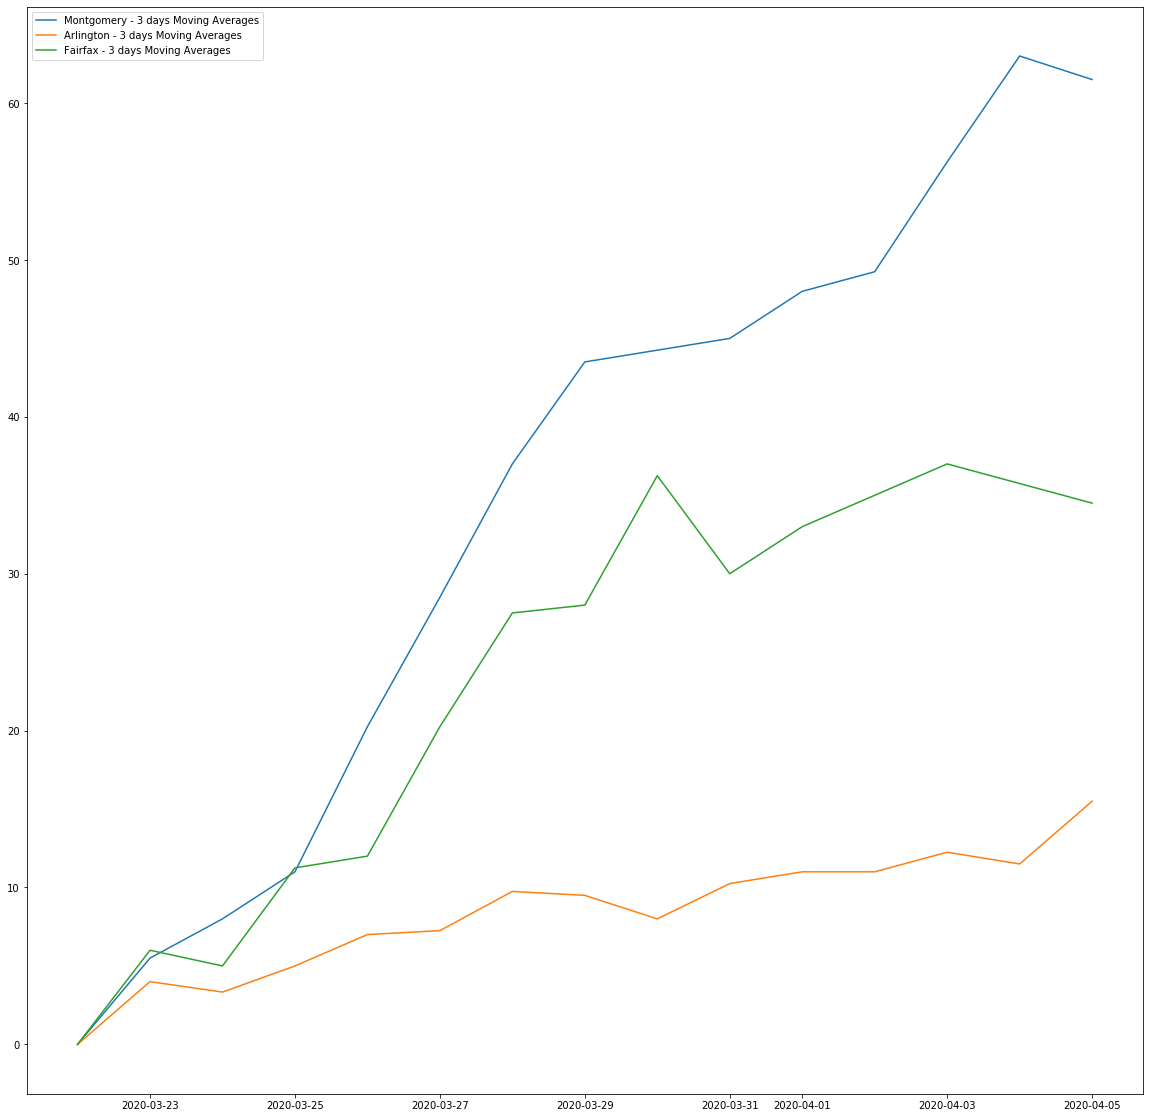

In [29]:
%local
plt.figure(figsize=(20,20))
for index in df_dmv_counties.index:
  plt.plot('date', 'movingAverage', data=df_dmv_movAvg.loc[df_dmv_movAvg['county']==df_dmv_counties['county'][index]],label=df_dmv_counties['county'][index] + ' - 3 days Moving Averages')
  plt.text
plt.legend()
plt.show()

In [30]:
rateChangeSpec = Window.partitionBy("county").orderBy("date").rowsBetween(-1,0)

df_dmv_rateChange = df_dmv.withColumn( "RateOfChange", F.avg("change").over(rateChangeSpec) )
df_dmv_rateChange.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------+------------+---------+------+------------+
|               date|    county|numConfirmed|dayBefore|change|RateOfChange|
+-------------------+----------+------------+---------+------+------------+
|2020-03-22 00:00:00|Montgomery|          83|     null|     0|         0.0|
|2020-03-23 00:00:00|Montgomery|          94|       83|    11|         5.5|
|2020-03-24 00:00:00|Montgomery|         107|       94|    13|        12.0|
|2020-03-25 00:00:00|Montgomery|         127|      107|    20|        16.5|
|2020-03-26 00:00:00|Montgomery|         164|      127|    37|        28.5|
|2020-03-27 00:00:00|Montgomery|         208|      164|    44|        40.5|
|2020-03-28 00:00:00|Montgomery|         255|      208|    47|        45.5|
|2020-03-29 00:00:00|Montgomery|         301|      255|    46|        46.5|
|2020-03-30 00:00:00|Montgomery|         341|      301|    40|        43.0|
|2020-03-31 00:00:00|Montgomery|         388|      341|    47|        43.5|
|2020-04-01 

In [31]:
%spark -o df_dmv_rateChange

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

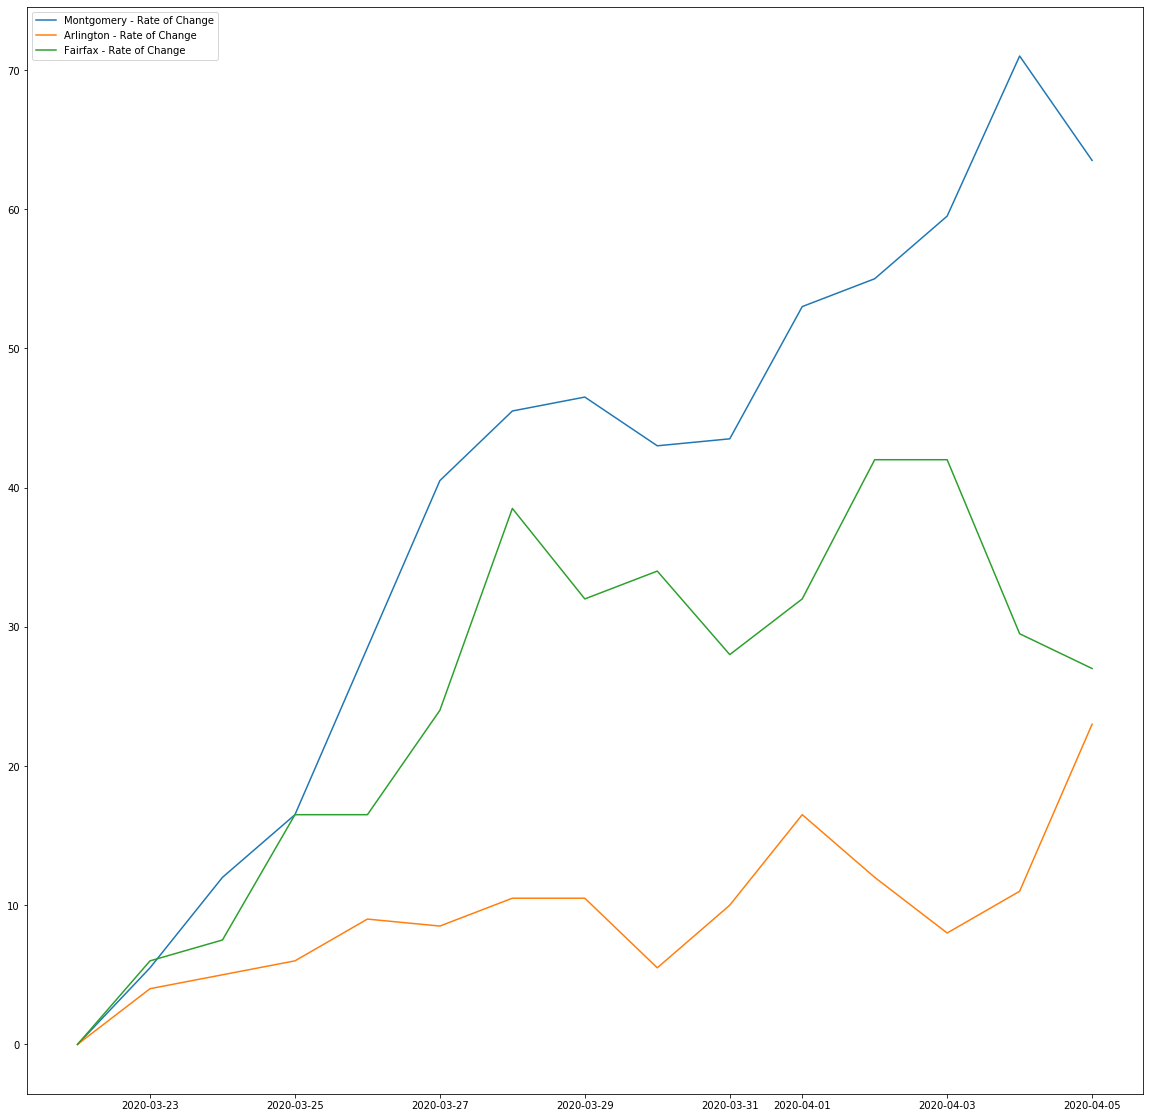

In [32]:
%local
plt.figure(figsize=(20,20))
for index in df_dmv_counties.index:
  plt.plot('date', 'RateOfChange', data=df_dmv_rateChange.loc[df_dmv_rateChange['county']==df_dmv_counties['county'][index]],label=df_dmv_counties['county'][index] + ' - Rate of Change')
  plt.text
plt.legend()
plt.show()